In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-white')


# 1. RNR

## 1.0 Reactor Data

### CLASS
#### Reactor
    - Heavy mass: 72 tons
    - Thermal power: 3 GWth
    - Irradiation time: 7 years that correspond to a burn-up closed to 80 GWd/t
    - Loading factor: 75%

#### FLM
    - 17x17 infinite assembly
    - Neural network prediction of the k$_{inf}$
    - k$_{threshold}$ is 1.034

### Tr_Evol
#### Reactor
    - Thermal_power_(GW) : 3.6
    - Electrical_power_(GW) : 1.44
    - Load_factor : 0.9
    - Core_mass_(tHM) : 45.0
    - Burn_up_(GWd/tHM) : 136
#### FLM
    - Baker \& Ross

### Josette
#### Reactor
    - Thermal_power_(GW) : 3.6
    - Load_factor : 1 ??
    - Core_mass_(tHM) : 71.4
    - Burn_up_(GWd/tHM) : 100
#### FLM
    - Baker \& Ross

## 1.1 Loading Data files and Variable declaration
### XAV / CLASS

In [2]:
def load_class_data(file = 'CLASS_CRNS_RNR/Data.dat'):
    M_CLASS = np.loadtxt(file)
    M_CLASS_FF_BOC = M_CLASS[::4]
    M_CLASS_FF_EOC = M_CLASS[1::4]
    M_CLASS_FLM_BOC = M_CLASS[2::4]
    M_CLASS_FLM_EOC = M_CLASS[3::4]
    
    total_mass = 72    
    
    M_CLASS_FLM_BOC_FPu = M_CLASS_FLM_BOC[:,3]/total_mass
    M_CLASS_FLM_EOC_FPu = M_CLASS_FLM_EOC[:,3]/total_mass
    M_CLASS_FF_BOC_FPu = M_CLASS_FF_BOC[:,3]/total_mass
    M_CLASS_FF_EOC_FPu = M_CLASS_FF_EOC[:,3]/total_mass
    
    return M_CLASS_FLM_BOC_FPu, M_CLASS_FLM_EOC_FPu, M_CLASS_FF_BOC_FPu, M_CLASS_FF_EOC_FPu




### BME

In [3]:
def load_josette_data(file = 'JOSETTE_BME/'):
    M_FF_BOC = np.loadtxt(file + "FF_BOC.txt")
    M_FF_EOC = np.loadtxt(file + "FF_EOC.txt")

    M_FLM_BOC = np.loadtxt(file + "FLM_BOC.txt")
    M_FLM_EOC = np.loadtxt(file + "FLM_EOC.txt")


    total_mass = 7.15E+01
    M_jos_FLM_BOC_FPu = M_FLM_BOC[:,3]/1e6 / total_mass
    M_jos_FLM_EOC_FPu = M_FLM_EOC[:,3]/1e6 / total_mass

    M_jos_FF_BOC_FPu = M_FF_BOC[:,3]/1e6 / total_mass
    M_jos_FF_EOC_FPu = M_FF_EOC[:,3]/1e6 / total_mass

    return M_jos_FLM_BOC_FPu, M_jos_FLM_EOC_FPu, M_jos_FF_BOC_FPu, M_jos_FF_EOC_FPu



### ARIS / TrEvol

In [4]:
def load_TrEvol_data(file = 'TREVOL_CIEMAT/SFR_raw.txt'):
    M_TrEvol = np.loadtxt(file)
    total_mass = 8.7
    M_TrEvol_FLM_BOC_FPu = M_TrEvol[:,23] / total_mass
    M_TrEvol_FLM_EOC_FPu = M_TrEvol[:,33] / total_mass

    M_TrEvol_FF_BOC_FPu = M_TrEvol[:,3] / total_mass
    M_TrEvol_FF_EOC_FPu = M_TrEvol[:,13] / total_mass

    return M_TrEvol_FLM_BOC_FPu, M_TrEvol_FLM_EOC_FPu, M_TrEvol_FF_BOC_FPu, M_TrEvol_FF_EOC_FPu




### Load Data

In [5]:
M_FLM_BOC_FPu = {}
M_FLM_EOC_FPu = {}
M_FF_BOC_FPu = {}
M_FF_EOC_FPu = {}

M_FLM_BOC_MUPu = {}

M_FLM_BOC_FPu['CLASS'], M_FLM_EOC_FPu['CLASS'], M_FF_BOC_FPu['CLASS'], M_FF_EOC_FPu['CLASS'] = load_class_data()
M_FLM_BOC_FPu['TrEvol'], M_FLM_EOC_FPu['TrEvol'], M_FF_BOC_FPu['TrEvol'], M_FF_EOC_FPu['TrEvol'] = load_TrEvol_data()
M_FLM_BOC_FPu['JOSETTE'], M_FLM_EOC_FPu['JOSETTE'], M_FF_BOC_FPu['JOSETTE'], M_FF_EOC_FPu['JOSETTE'] = load_josette_data()


PWR_MASS = {}
PWR_MASS['CLASS'] = 72
PWR_MASS['TrEvol'] = 8.7
PWR_MASS['JOSETTE'] = 7.14E+01



PWR_CYCLE = {}
PWR_CYCLE['CLASS'] =  80 / (3*0.75) * PWR_MASS['CLASS'] /365.25
PWR_CYCLE['TrEvol'] = 135 / (3.6*0.9) * PWR_MASS['TrEvol'] /365.25
PWR_CYCLE['JOSETTE'] = 100 / (3.6) * PWR_MASS['JOSETTE'] /365.25




colors = {}
colors['CLASS'] = "red"
colors['TrEvol'] = "green"
colors['JOSETTE'] = "chartreuse"




## Methods

### Estimators

#### Estimator 1
Estimator 1 is calculated from the Pu fraction @ B.O.C. for each run *i*: 

$F(Pu_i) = \frac{Pu_i^{BOC}}{M_{HN}}$

With $M_{HN}$ the initial heavy mass. The estimator 1 is then calculated as : 

$\delta F(Pu_i) = \frac{F_{FLM}(Pu_i) - F_{FF}(Pu_i)}{F_{FF}(Pu_i)}$

In [6]:
ESTIMATOR_1 = {}
_codes = ['CLASS', 'TrEvol', 'JOSETTE']
for code in _codes:
    ESTIMATOR_1[code] = (M_FLM_BOC_FPu[code] - M_FF_BOC_FPu[code] ) /M_FF_BOC_FPu[code]


#### Estimator 2b

The second estimator is related to the relative slope of the reactor evolution. Let's define :

$\frac{\Delta M}{M}(Pu_i) = \frac{M^{BOC}(Pu_i) - M^{EOC}(Pu_i)}{M^{BOC}(Pu_i)}$

The estimateur 2 is then the relative difference of this observable : 

$\Delta \frac{\Delta M}{M}(Pu_i) = \frac{\Delta M}{M}(Pu_i)_{FLM} - \frac{\Delta M}{M}(Pu_i)_{FF}$

In [7]:
ESTIMATOR_2b = {}
_codes = ['CLASS', 'TrEvol', 'JOSETTE']


for code in _codes:
    _fml = (M_FLM_BOC_FPu[code] -  M_FLM_EOC_FPu[code])/M_FLM_BOC_FPu[code]
    _ff = (M_FF_BOC_FPu[code] -  M_FF_EOC_FPu[code])/M_FF_BOC_FPu[code]
    ESTIMATOR_2b[code] = (_fml - _ff)



#### Estimator 3

The third estimator is related to the absolute slope of the reactor evolution. we define :

$\frac{\Delta M}{\Delta t}(Pu_i) = \frac{M^{BOC}(Pu_i) - M^{EOC}(Pu_i)}{\Delta t}$

The estimateur 3 is then the relative difference of this observable : 

$\delta \frac{\Delta M}{\Delta t}(Pu_i) = \frac{\frac{\Delta M}{\Delta t}(Pu_i)_{FLM} - \frac{\Delta M}{\Delta t}(Pu_i)_{FF}}{\frac{\Delta M}{\Delta t}(Pu_i)_{FF}}$

In [8]:
ESTIMATOR_3 = {}

_codes = ['CLASS', 'TrEvol', 'JOSETTE']

for code in _codes:
    _fml = (M_FLM_BOC_FPu[code] -  M_FLM_EOC_FPu[code])* PWR_MASS[code]/PWR_CYCLE[code]
    _ff = (M_FF_BOC_FPu[code] -  M_FF_EOC_FPu[code])* PWR_MASS[code]/PWR_CYCLE[code]
    ESTIMATOR_3[code] = (_fml - _ff)


### Plots

In [9]:
def plot_pu(datas_boc, datas_eoc, labels=[], bins=[], x_label='Mass Fraction', y_label='Density', title_label='SFR MOX FLM - Pu distribution', range=(0,0.20)):

    fig, axs = plt.subplots(len(labels), 1, sharex=True, figsize=(12, 10))
    fig.subplots_adjust(hspace=0.0)

    #plt.title(title_label,fontsize=20)
    axs[0].set_title(title_label,fontsize=12)
    plt.xlabel(x_label,fontsize=12)

    #plt.ylabel('Number of Occurences')
    for i, label in enumerate(labels):
        bin = 0
        if len(bins) >0:
            bin = bins[i]
        data_boc = datas_boc[label]
        data_eoc = datas_eoc[label]

        axs[i].grid(True)
        axs[i].set_ylabel(y_label,fontsize=12)
        axs[i].hist(data_boc,bins=bin,range=range,histtype='stepfilled', alpha=1.0, density=True,lw=2,label='B.O.C.', color="black")
        axs[i].hist(data_eoc,bins=bin,range=range,histtype='stepfilled', alpha=0.4, density=True,lw=2,label='E.O.C.', color="red")
        axs[i].text(0.8, 0.8,label,horizontalalignment='center',verticalalignment='center',transform = axs[i].transAxes, fontsize=15)
        axs[i].legend(loc='upper right',prop={'size': 12})
    plt.show()
    fig.savefig("FIG/SFR_MOX_FLM_Pu.pdf")

In [10]:
def plot_estimator(datas,labels=[], bins=[], x_label='X', y_label='Y', title_label='Title', range=(0,1)):

    fig, axs = plt.subplots(len(labels), 1, sharex=True, figsize=(12, 10))
    fig.subplots_adjust(hspace=0.0)

    #plt.title(title_label,fontsize=20)
    axs[0].set_title(title_label,fontsize=12)
    plt.xlabel(x_label,fontsize=12)

    #plt.ylabel('Number of Occurences')
    for i, label in enumerate(labels):
        bin = 0
        if len(bins) >0:
            bin = bins[i]
        data = datas[label]

        axs[i].grid(True)
        axs[i].set_ylabel(y_label,fontsize=12)
        axs[i].hist(data,bins=bin,range=range,histtype='step', alpha=1.0, density=True,lw=3,color="black")
        axs[i].text(0.8, 0.8,label,horizontalalignment='center',verticalalignment='center',transform = axs[i].transAxes, fontsize=15)
    plt.show()
    fig.savefig("FIG/"+title_label+".pdf")

### Print

In [11]:
def print_means_pu(code):
    print("----------------------------------------")
    print("Mean value")
    print("----------------------------------------")
    print("-----",code,"-----")
    print("FLM : ")      
    print("Pu @BOC : ",np.mean(M_FLM_BOC_FPu[code])," - Pu @EOC : ",np.mean(M_FLM_EOC_FPu[code]))
    print ("FF : ")      
    print("Pu @BOC : ",np.mean(M_FF_BOC_FPu[code])," - Pu @EOC : ",np.mean(M_FF_EOC_FPu[code]))
    print("\n")
    

def print_std_pu(code):
    print("----------------------------------------")
    print("Standard Deviation")
    print("----------------------------------------")
    print("-----",code,"-----")
    print("FLM : ")      
    print("Pu @BOC : ",np.std(M_FLM_BOC_FPu[code])," - Pu @EOC : ",np.std(M_FLM_EOC_FPu[code]))
    print ("FF : ")      
    print("Pu @BOC : ",np.std(M_FF_BOC_FPu[code])," - Pu @EOC : ",np.std(M_FF_EOC_FPu[code]))
    print("\n")

In [12]:
def print_means_estimator(code,est):
    print("----------------------------------------")
    print("Mean value")
    print("----------------------------------------")
    print("-----",code,"-----")
    print("estimator : ",np.mean(est[code]))
    print("\n")
    

def print_std_estimator(code,est):
    print("----------------------------------------")
    print("Standard Deviation")
    print("----------------------------------------")
    print("-----",code,"-----")
    print("estimator : ",np.std(est[code]))
    print("\n")

## 1.2 Plotting Pu for FLM @ BOC and EOC

In [13]:
codes = ['CLASS', 'TrEvol', 'JOSETTE']

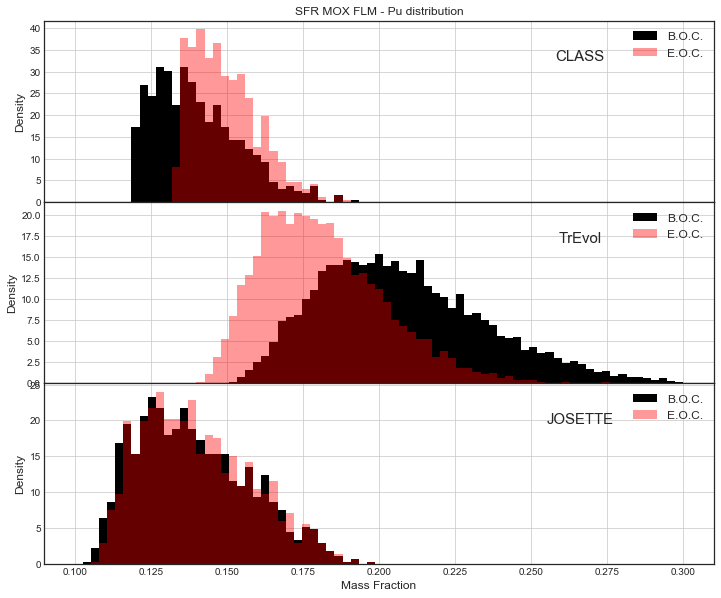

In [14]:
bins = [75, 75, 75, 75]

plot_pu(M_FLM_BOC_FPu, M_FLM_EOC_FPu, bins=bins, labels=codes, range=(0.10,0.30))



## 1.3 Mean value estimators

In [15]:
for code in codes:
    print_means_pu(code)

for code in codes:
    print_std_pu(code)

----------------------------------------
Mean value
----------------------------------------
----- CLASS -----
FLM : 
Pu @BOC :  0.14006475018896447  - Pu @EOC :  0.1495909223356009
FF : 
Pu @BOC :  0.16  - Pu @EOC :  0.1596333767951625


----------------------------------------
Mean value
----------------------------------------
----- TrEvol -----
FLM : 
Pu @BOC :  0.20791122731979675  - Pu @EOC :  0.18138207861282837
FF : 
Pu @BOC :  0.21435086345618312  - Pu @EOC :  0.1839017064638364


----------------------------------------
Mean value
----------------------------------------
----- JOSETTE -----
FLM : 
Pu @BOC :  0.13906911109090908  - Pu @EOC :  0.14049214254545453
FF : 
Pu @BOC :  0.15030306937062937  - Pu @EOC :  0.15010301062937062


----------------------------------------
Standard Deviation
----------------------------------------
----- CLASS -----
FLM : 
Pu @BOC :  0.014111665645807831  - Pu @EOC :  0.010864589904543687
FF : 
Pu @BOC :  0.0  - Pu @EOC :  0.00386892166810332

## 1.4 Plotting estimator 1

Estimator 1 is calculated from the Pu fraction @ B.O.C. for each run *i*: 

$F(Pu_i) = \frac{Pu_i^{BOC}}{M_{HN}}$

With $M_{HN}$ the initial heavy mass. The estimator 1 is then calculated as : 

$\delta F(Pu_i) = \frac{F_{FLM}(Pu_i) - F_{FF}(Pu_i)}{F_{FF}(Pu_i)}$

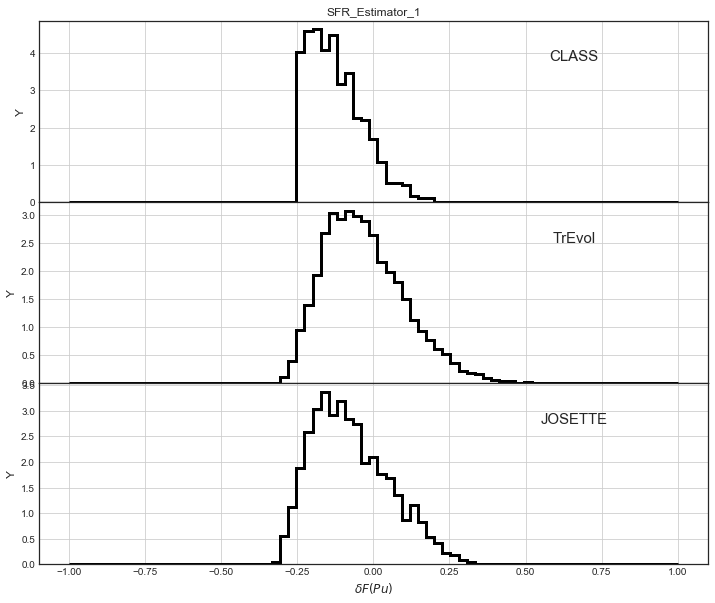

----------------------------------------
Mean value
----------------------------------------
----- CLASS -----
estimator :  -0.12459531131897206


----------------------------------------
Mean value
----------------------------------------
----- TrEvol -----
estimator :  -0.029325867213994217


----------------------------------------
Mean value
----------------------------------------
----- JOSETTE -----
estimator :  -0.0740947209877863


----------------------------------------
Standard Deviation
----------------------------------------
----- CLASS -----
estimator :  0.08819791028629895


----------------------------------------
Standard Deviation
----------------------------------------
----- TrEvol -----
estimator :  0.1327773156410563


----------------------------------------
Standard Deviation
----------------------------------------
----- JOSETTE -----
estimator :  0.1258681829734082




In [16]:
bins = [75, 75, 75, 75]
plot_estimator(ESTIMATOR_1, bins=bins, labels=codes, title_label='SFR_Estimator_1', x_label='$\delta F(Pu)$', range=(-1.,1.))


for code in codes:
    print_means_estimator(code,ESTIMATOR_1)

for code in codes:
    print_std_estimator(code,ESTIMATOR_1)    

## 1.5 Plotting Estimator 2b

The second estimator is related to the relative slope of the reactor evolution. Let's define :

$\frac{\Delta M}{M}(Pu_i) = \frac{M^{BOC}(Pu_i) - M^{EOC}(Pu_i)}{M^{BOC}(Pu_i)}$

The estimateur 2 is then the relative difference of this observable : 

$\delta \frac{\Delta M}{M}(Pu_i) = \frac{\Delta M}{M}(Pu_i)_{FLM} - \frac{\Delta M}{M}(Pu_i)_{FF}$

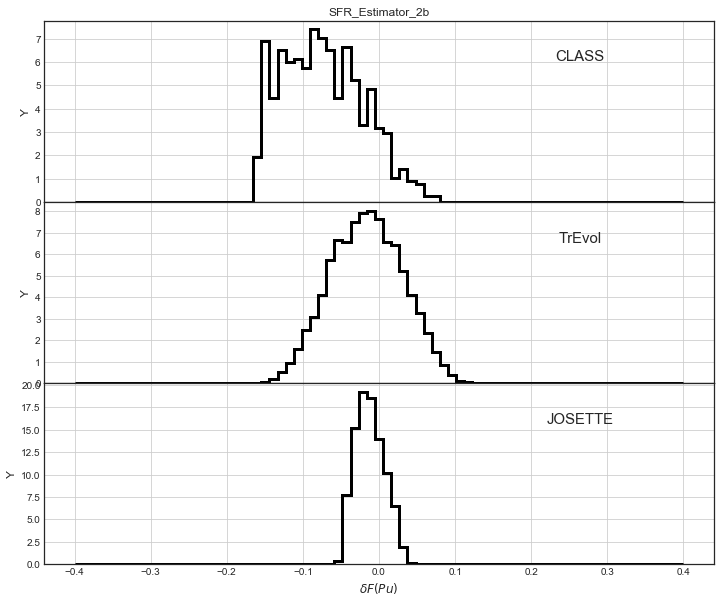

----------------------------------------
Mean value
----------------------------------------
----- CLASS -----
estimator :  -0.07319481391162887


----------------------------------------
Mean value
----------------------------------------
----- TrEvol -----
estimator :  -0.016780234826100013


----------------------------------------
Mean value
----------------------------------------
----- JOSETTE -----
estimator :  -0.01210349884951185


----------------------------------------
Standard Deviation
----------------------------------------
----- CLASS -----
estimator :  0.052470837552508476


----------------------------------------
Standard Deviation
----------------------------------------
----- TrEvol -----
estimator :  0.04689136386102409


----------------------------------------
Standard Deviation
----------------------------------------
----- JOSETTE -----
estimator :  0.01871585667431968




In [17]:
bins = [75, 75, 75, 75]

plot_estimator(ESTIMATOR_2b, bins=bins, labels=codes, title_label='SFR_Estimator_2b', x_label='$\delta F(Pu)$', range=(-0.4,0.4))


for code in codes:
    print_means_estimator(code,ESTIMATOR_2b)

for code in codes:
    print_std_estimator(code,ESTIMATOR_2b)    

## 1.5 Plotting Estimator 3

The third estimator is related to the absolute slope of the reactor evolution. we define :

$\frac{\Delta M}{\Delta t}(Pu_i) = \frac{M^{BOC}(Pu_i) - M^{EOC}(Pu_i)}{\Delta t}$

The estimateur 3 is then the relative difference of this observable : 

$\delta \frac{\Delta M}{\Delta t}(Pu_i) = \frac{\frac{\Delta M}{\Delta t}(Pu_i)_{FLM} - \frac{\Delta M}{\Delta t}(Pu_i)_{FF}}{\frac{\Delta M}{\Delta t}(Pu_i)_{FF}}$

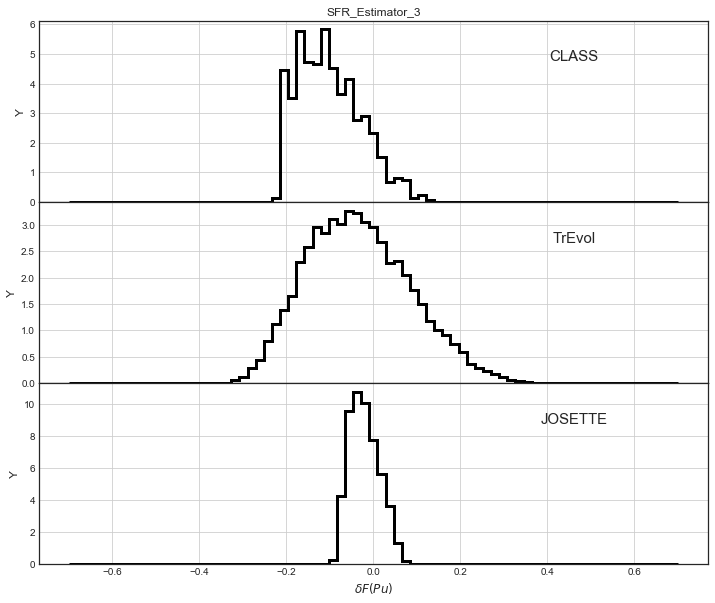

----------------------------------------
Mean value
----------------------------------------
----- CLASS -----
estimator :  -0.10162528599728958


----------------------------------------
Mean value
----------------------------------------
----- TrEvol -----
estimator :  -0.0343627926296267


----------------------------------------
Mean value
----------------------------------------
----- JOSETTE -----
estimator :  -0.021342012984629365


----------------------------------------
Standard Deviation
----------------------------------------
----- CLASS -----
estimator :  0.07225186546964821


----------------------------------------
Standard Deviation
----------------------------------------
----- TrEvol -----
estimator :  0.11893744649070902


----------------------------------------
Standard Deviation
----------------------------------------
----- JOSETTE -----
estimator :  0.03390579419691841




In [18]:
bins = [75, 75, 75, 75]


plot_estimator(ESTIMATOR_3, bins=bins, labels=codes, title_label='SFR_Estimator_3', x_label='$\delta F(Pu)$', range=(-0.7,0.7))


for code in codes:
    print_means_estimator(code,ESTIMATOR_3)

for code in codes:
    print_std_estimator(code,ESTIMATOR_3)    